[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/pixeltable/pixeltable/blob/release/docs/notebooks/integrations/working-with-gemini.ipynb)&nbsp;&nbsp;
[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pixeltable/pixeltable/blob/release/docs/notebooks/integrations/working-with-gemini.ipynb)&nbsp;&nbsp;
<a href="https://raw.githubusercontent.com/pixeltable/pixeltable/release/docs/notebooks/integrations/working-with-gemini.ipynb" download><img src="https://img.shields.io/badge/%E2%AC%87-Download%20Notebook-blue" alt="Download Notebook"></a>

# Working with Gemini in Pixeltable

Pixeltable's Gemini integration enables you to access the Gemini LLM via the Google Gemini API.

### Prerequisites

- A Google AI Studio account with an API key (https://aistudio.google.com/app/apikey)

### Important Notes

- Google AI Studio usage may incur costs based on your plan.
- Be mindful of sensitive data and consider security measures when integrating with external services.

First you'll need to install required libraries and enter a Gemini API key obtained via Google AI Studio.

In [ ]:
%pip install -qU pixeltable google-genai

In [ ]:
import os
import getpass

if 'GEMINI_API_KEY' not in os.environ:
    os.environ['GEMINI_API_KEY'] = getpass.getpass('Google AI Studio API Key:')

Now let's create a Pixeltable directory to hold the tables for our demo.

In [1]:
import pixeltable as pxt

# Remove the `gemini_demo` directory and its contents, if it exists
pxt.drop_dir('gemini_demo', force=True)
pxt.create_dir('gemini_demo')

Connected to Pixeltable database at: postgresql+psycopg://postgres:@/pixeltable?host=/Users/asiegel/.pixeltable/pgdata
Created directory 'gemini_demo'.


## Generate Content

Create a Table: In Pixeltable, create a table with columns to represent your input data and the columns where you want to store the results from Gemini.

In [2]:
from google.genai.types import GenerateContentConfigDict
from pixeltable.functions import gemini

# Create a table in Pixeltable and pick a model hosted on Google AI Studio with some parameters

t = pxt.create_table('gemini_demo.text', {'input': pxt.String})

config = GenerateContentConfigDict(
    stop_sequences=['\n'],
    max_output_tokens=300,
    temperature=1.0,
    top_p=0.95,
    top_k=40,
)
t.add_computed_column(output=gemini.generate_content(
    t.input,
    model='gemini-2.0-flash',
    config=config
))

Created table `text`.
Added 0 column values with 0 errors.


UpdateStatus(num_rows=0, num_computed_values=0, num_excs=0, updated_cols=[], cols_with_excs=[])

In [3]:
# Ask Gemini to generate some content based on the input
t.insert([
    {'input': 'Write a story about a magic backpack.'}, 
    {'input': 'Tell me a science joke.'}
])

Inserting rows into `text`: 2 rows [00:00, 185.46 rows/s]
Inserted 2 rows with 0 errors.


UpdateStatus(num_rows=2, num_computed_values=4, num_excs=0, updated_cols=[], cols_with_excs=[])

In [4]:
# Parse the response into a new column
t.add_computed_column(response=t.output['candidates'][0]['content']['parts'][0]['text'])
t.select(t.input, t.response).head()

Added 2 column values with 0 errors.


input,response
Tell me a science joke.,Why did the chemist make such a good detective?
Write a story about a magic backpack.,"Elara found it tucked away in the dusty corner of Mrs. Willowbrook's antique shop, hidden behind a chipped porcelain doll and a stack of moth-eaten tapestries. It wasn't the backpack's appearance that drew her in, but the almost imperceptible hum that vibrated from its worn leather. It was a simple, brown rucksack, fastened with tarnished brass buckles and smelling faintly of sandalwood and forgotten adventures."


## Generate Images with Imagen

In [5]:
from google.genai.types import GenerateImagesConfigDict

images_t = pxt.create_table('gemini_demo.images', {'prompt': pxt.String})

config = GenerateImagesConfigDict(aspect_ratio='4:3')
images_t.add_computed_column(generated_image=gemini.generate_images(
    images_t.prompt,
    model='imagen-3.0-generate-002',
    config=config
))

Created table `images`.
Added 0 column values with 0 errors.


UpdateStatus(num_rows=0, num_computed_values=0, num_excs=0, updated_cols=[], cols_with_excs=[])

In [6]:
images_t.insert([{'prompt': 'A friendly dinosaur playing tennis in a cornfield'}])

Inserting rows into `images`: 1 rows [00:00, 363.36 rows/s]
Inserted 1 row with 0 errors.


UpdateStatus(num_rows=1, num_computed_values=2, num_excs=0, updated_cols=[], cols_with_excs=[])

prompt,generated_image
A friendly dinosaur playing tennis in a cornfield,

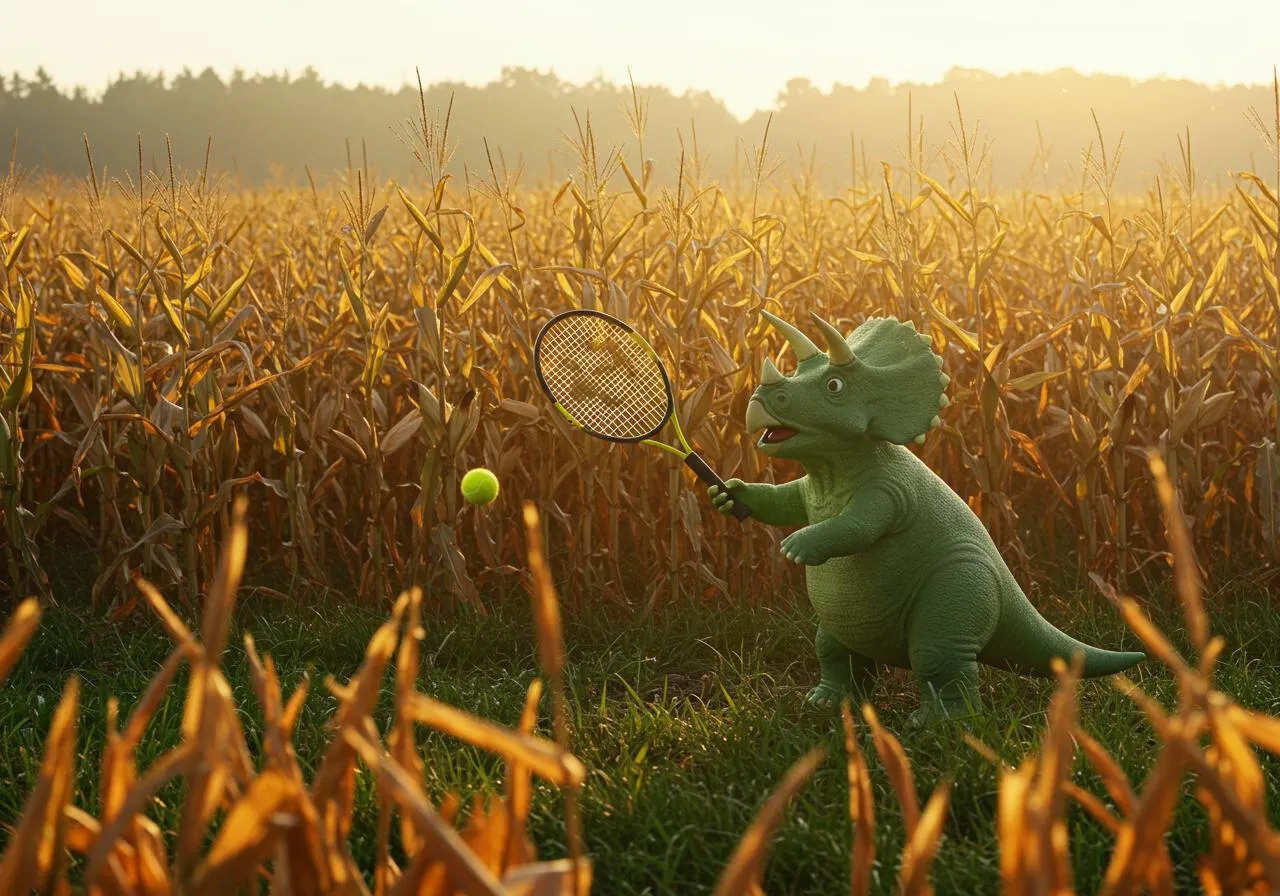

In [7]:
images_t.head()

## Generate Video with Veo

In [8]:
videos_t = pxt.create_table('gemini_demo.videos', {'prompt': pxt.String})

videos_t.add_computed_column(generated_video=gemini.generate_videos(
    videos_t.prompt,
    model='veo-2.0-generate-001',
))  

Created table `videos`.
Added 0 column values with 0 errors.


UpdateStatus(num_rows=0, num_computed_values=0, num_excs=0, updated_cols=[], cols_with_excs=[])

In [9]:
videos_t.insert([{'prompt': 'A giant pixel floating over the open ocean in a sea of data'}])

Inserting rows into `videos`: 1 rows [00:00, 99.74 rows/s]
Inserted 1 row with 0 errors.


UpdateStatus(num_rows=1, num_computed_values=2, num_excs=0, updated_cols=[], cols_with_excs=[])

prompt,generated_video
A giant pixel floating over the open ocean in a sea of data,

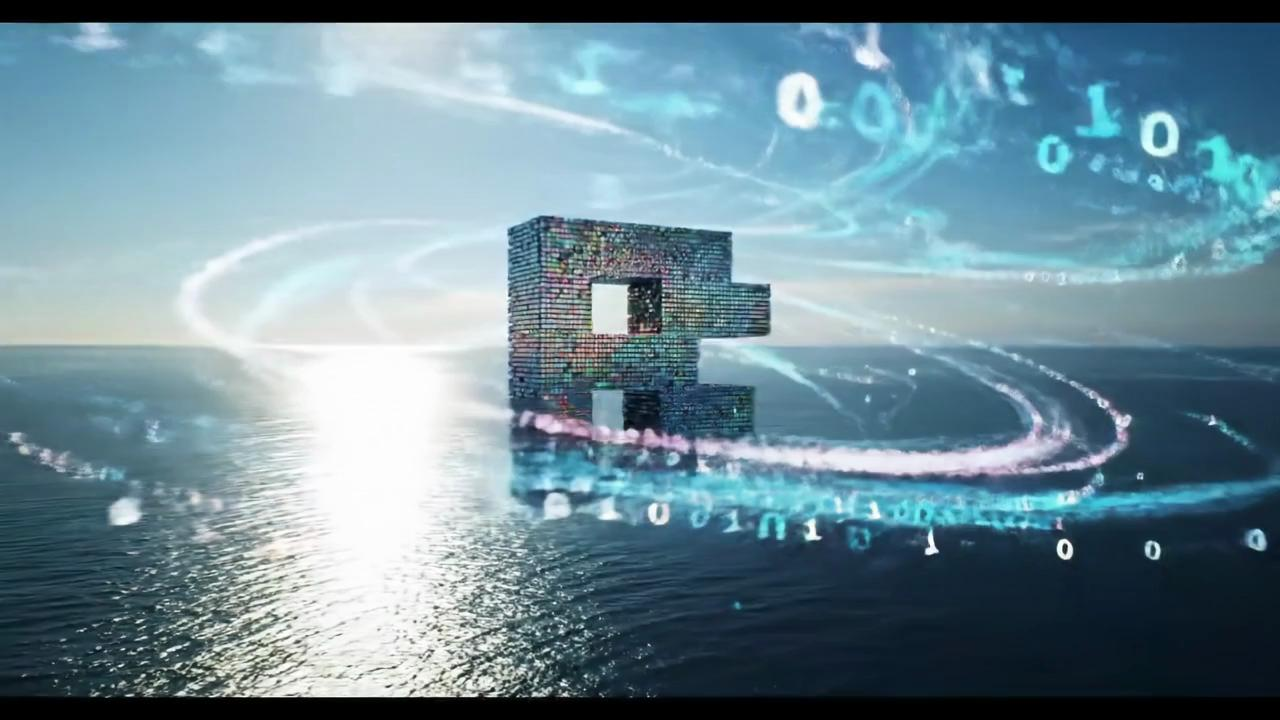

In [10]:
videos_t.head()

## Generate Video from an existing Image

We'll add an additional computed column to our existing `images_t` to animate the generated images.

In [12]:
images_t.add_computed_column(generated_video=gemini.generate_videos(
    image=images_t.generated_image,
    model='veo-2.0-generate-001',
))

Added 1 column value with 0 errors.


UpdateStatus(num_rows=1, num_computed_values=1, num_excs=0, updated_cols=[], cols_with_excs=[])

prompt,generated_image,generated_video
A friendly dinosaur playing tennis in a cornfield,,

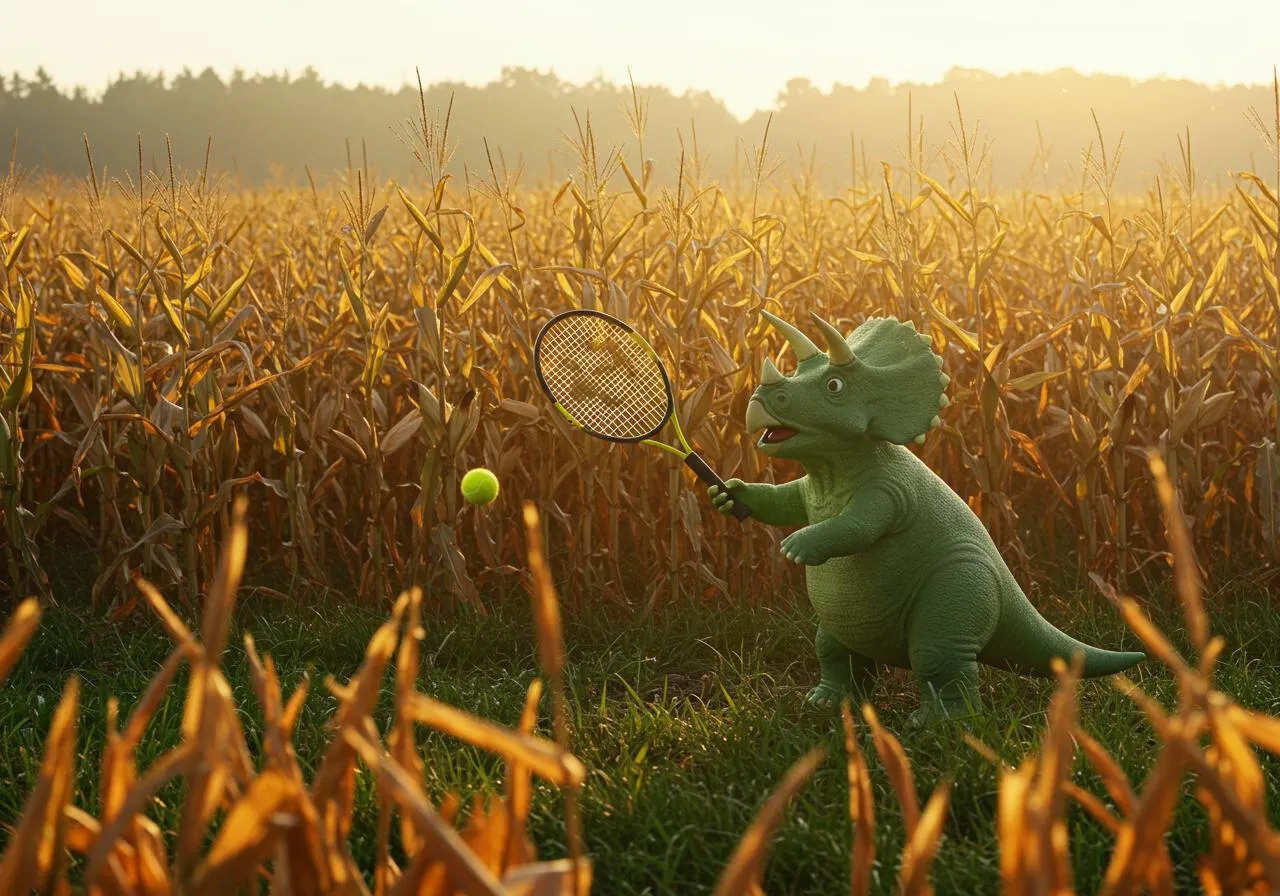
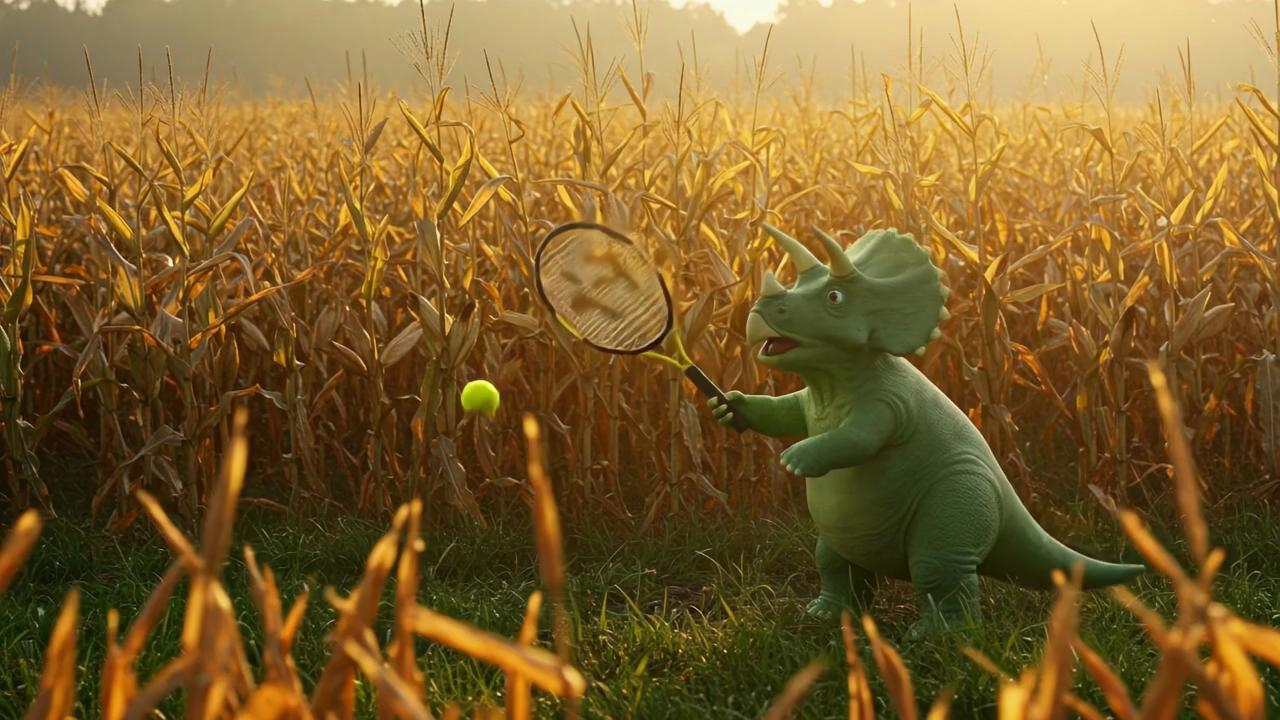

In [14]:
images_t.head()

### Learn More

To learn more about advanced techniques like RAG operations in Pixeltable, check out the [RAG Operations in Pixeltable](https://pixeltable.readme.io/docs/rag-operations-in-pixeltable) tutorial.

If you have any questions, don't hesitate to reach out.